## Using Cellpose for Segmentation
Here, we use Cellpose to automatically segment the nuclei images roughly. Later, manual correction will be performed by visual inspection.

The necessary modules will be imported in the following section.

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyclesperanto_prototype as cle
from cellpose import models, io, utils, plot
from skimage import data
from skimage.io import imread, imsave, imshow
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, watershed
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import tifffile
import napari
from tifffile import imwrite

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Get current directory path
current_directory = os.getcwd()
# Get the path two levels above the current directory
dir = os.path.dirname(current_directory)

/Volumes/Public-TS-873/Microscope/Ochiai/240301-seqFISH-MMB/240314-image_analysis_v4/seqFISH_analysis_test


## Nucleus segmentation by Cellpose
In the next cell, Cellpose is used to perform segmentation of the nuclear regions.

100%|███████████████████████████████████████| 108/108 [00:00<00:00, 3035.77it/s]


Available OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz', 'AMD Radeon Pro 5500 XT Compute Engine']
Available GPU OpenCL devices:['AMD Radeon Pro 5500 XT Compute Engine']
Available CPU OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz']
Loaded image size: (108, 379, 348)
Image size in GPU: (108, 379, 348)


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1026.25it/s]


Available OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz', 'AMD Radeon Pro 5500 XT Compute Engine']
Available GPU OpenCL devices:['AMD Radeon Pro 5500 XT Compute Engine']
Available CPU OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz']
Loaded image size: (127, 381, 349)
Image size in GPU: (127, 381, 349)


100%|███████████████████████████████████████| 109/109 [00:00<00:00, 1228.47it/s]


Available OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz', 'AMD Radeon Pro 5500 XT Compute Engine']
Available GPU OpenCL devices:['AMD Radeon Pro 5500 XT Compute Engine']
Available CPU OpenCL devices:['Intel(R) Core(TM) i9-10910 CPU @ 3.60GHz']
Loaded image size: (109, 377, 345)
Image size in GPU: (109, 377, 345)


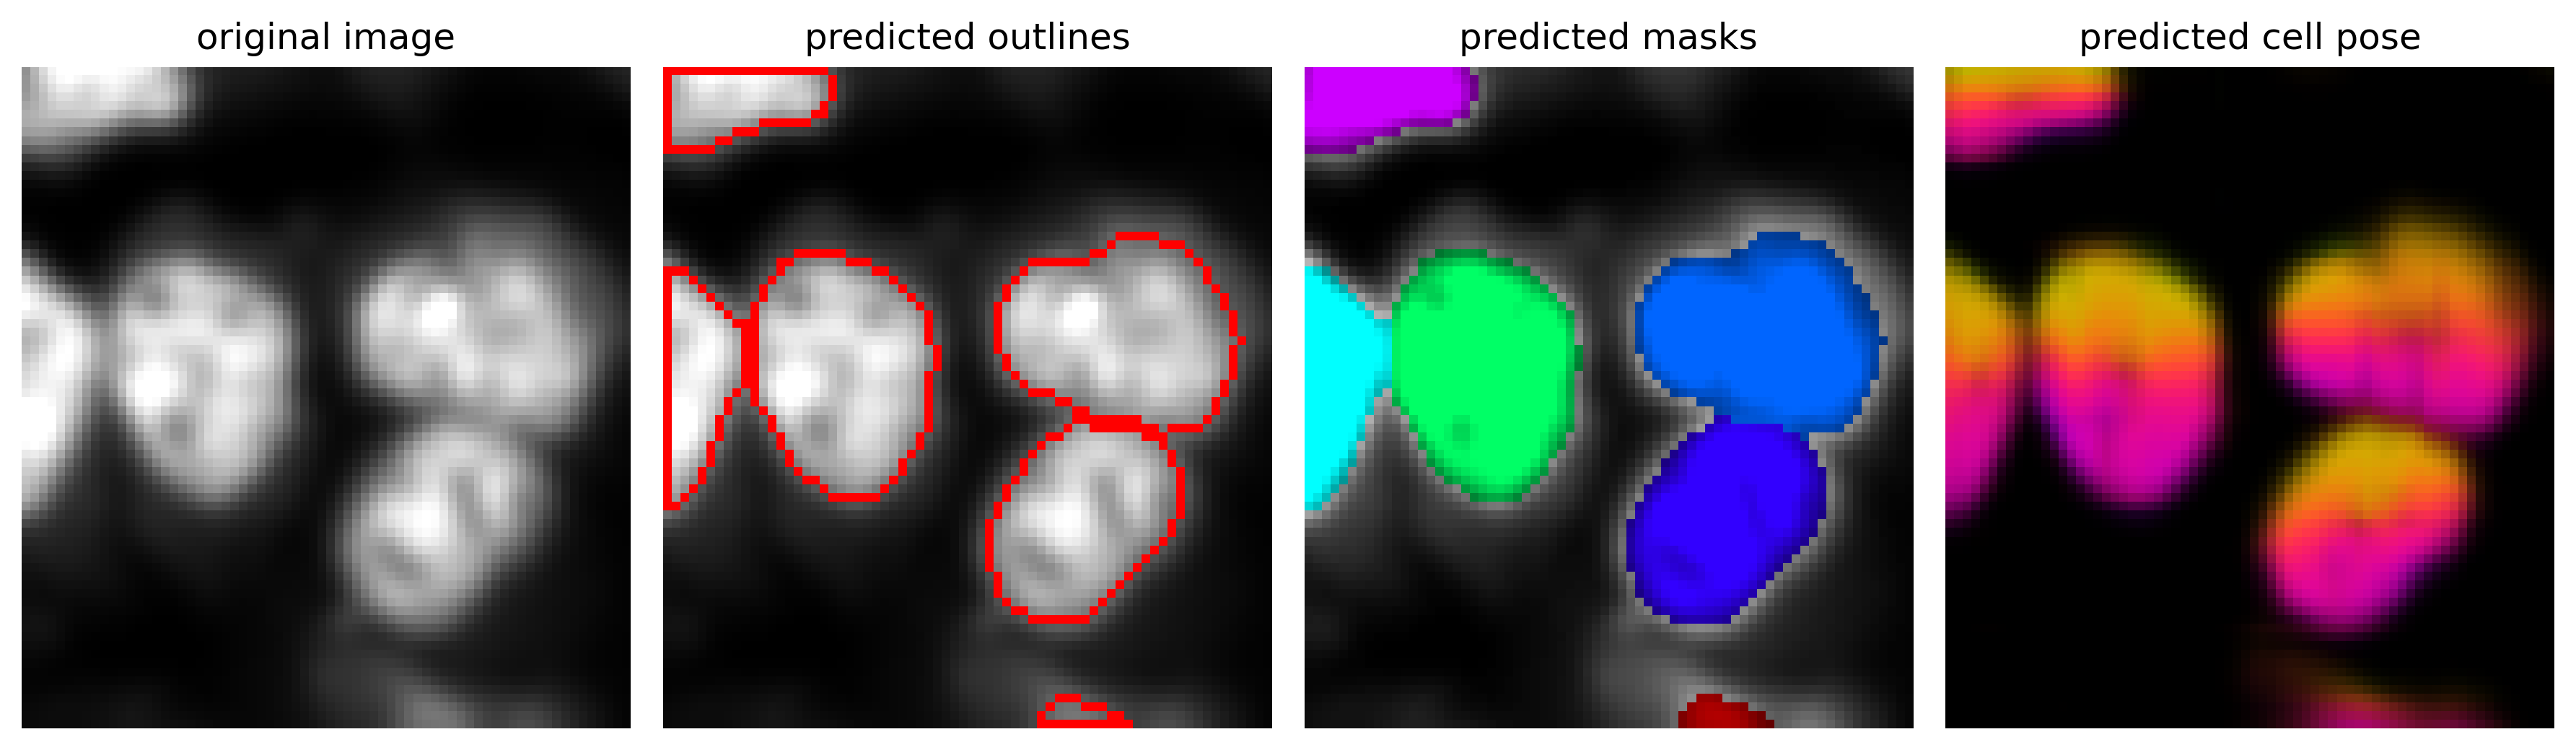

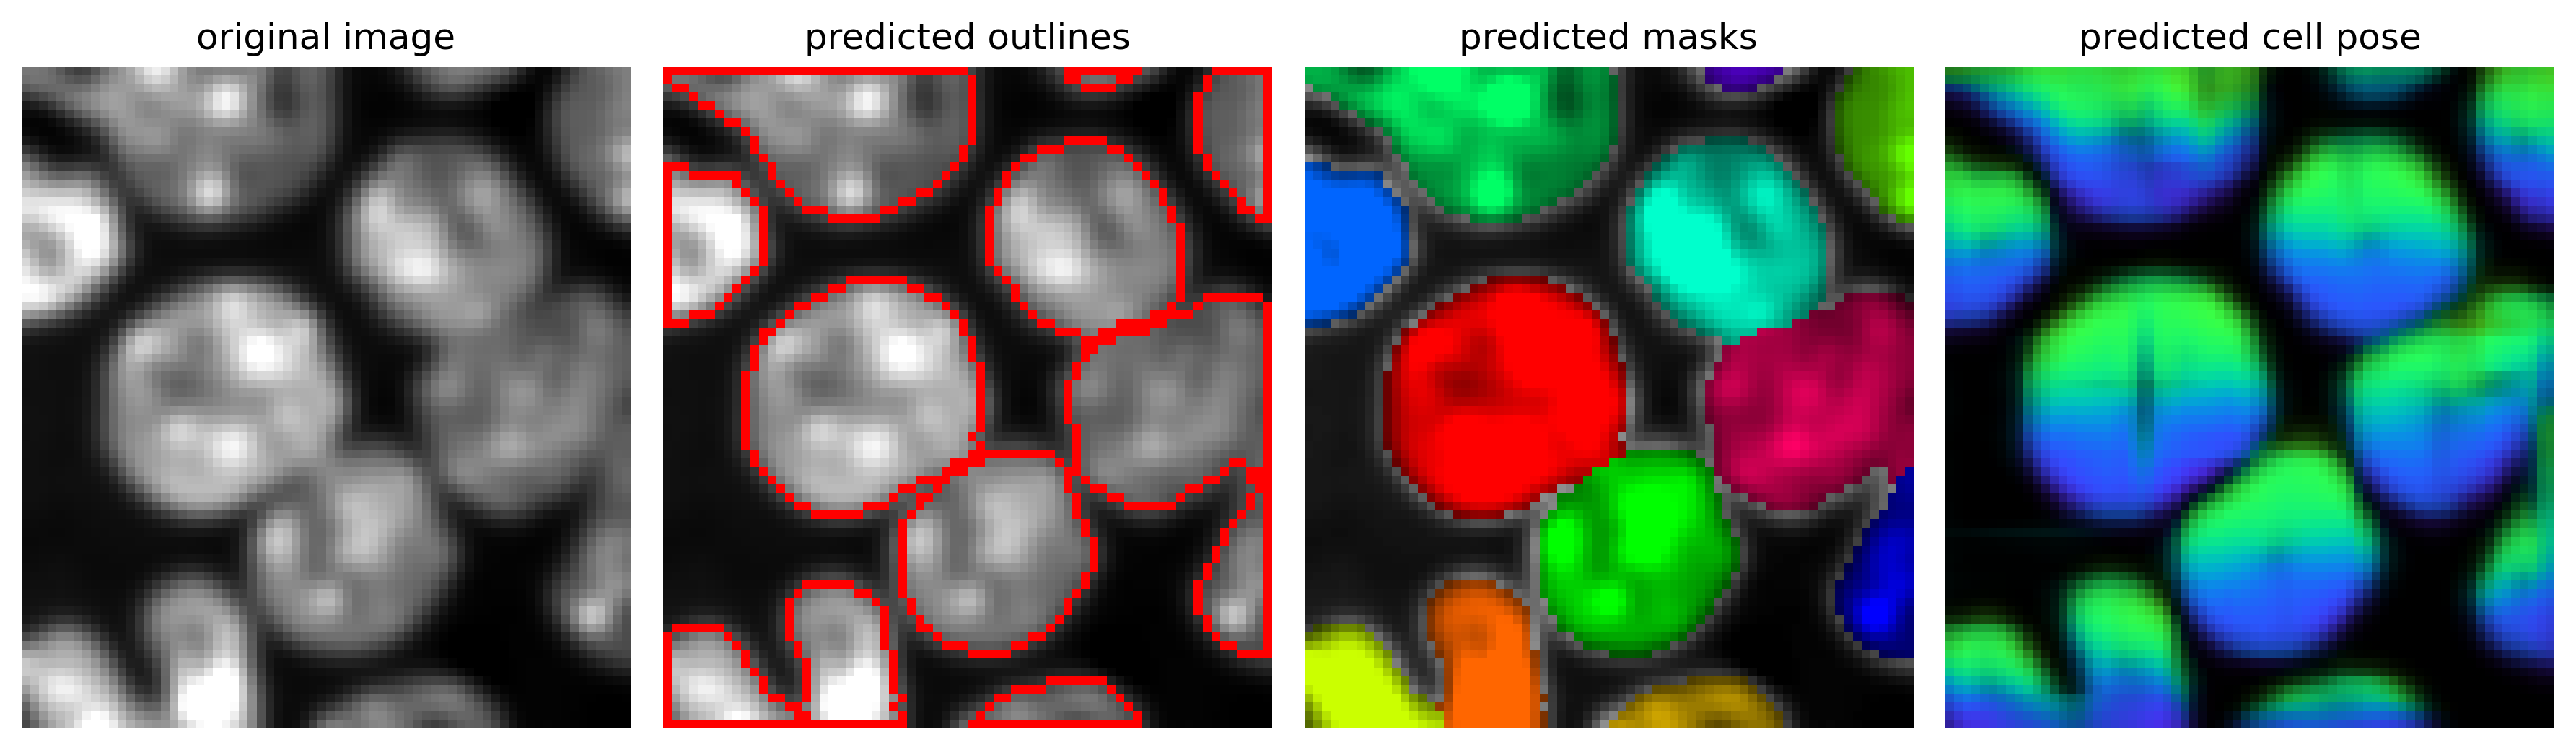

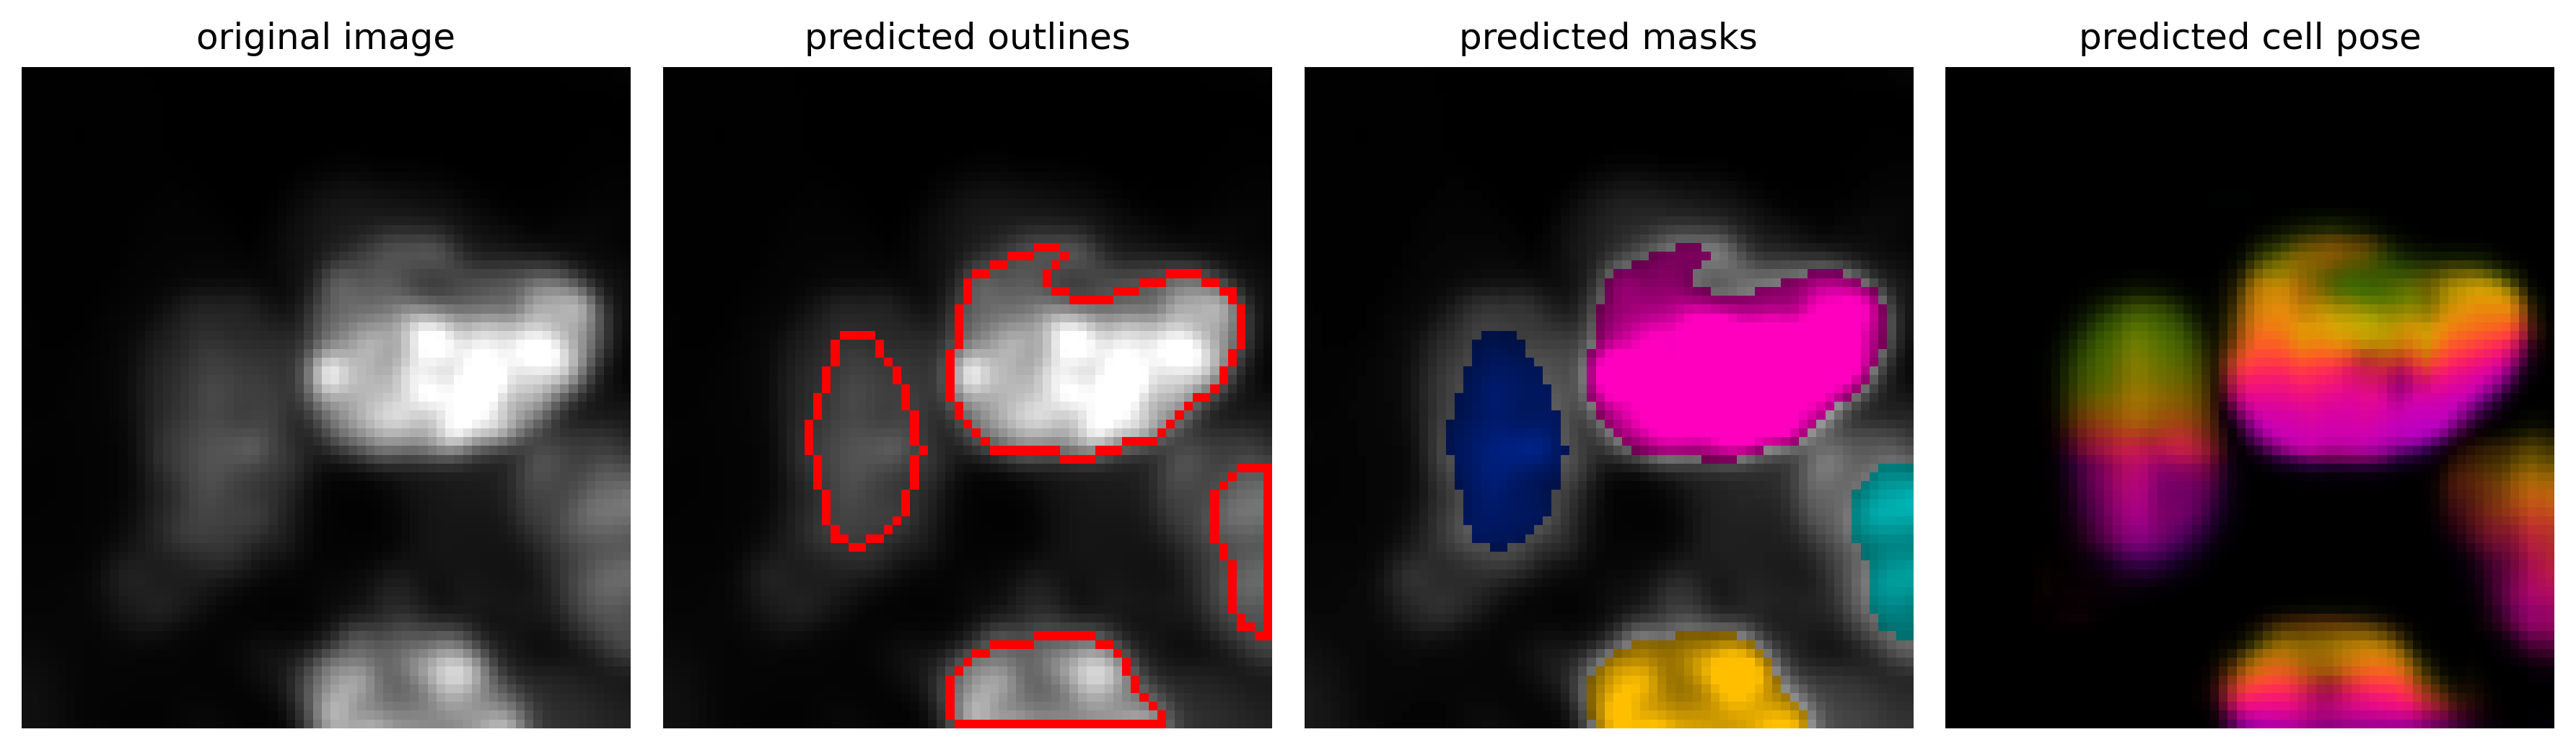

In [5]:
   
# hard-code the paths of our input and output directories
path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

# Select the position to be analyzed.
pos_num =("Pos01", "Pos02", "Pos03")


for i in range(len(pos_num)) :
    # Image of cell nuclei at the end of RNA-seqFISH.
    nuc_path = os.path.join(path_input, pos_num[i], "ND31_C4_TyR.tif")
    img_nuc = io.imread(nuc_path)
    img_nuc_dim = img_nuc.shape # Insert z, y, x information.
    # Since the number of z varies depending on the image, determine the number corresponding to the center of Z as med_z.。
    med_z = round(img_nuc_dim[0]/2)
    
    
    # Compressed to 1/5 the size, necessary for good segmentation in Cellpose, otherwise it will not work well.
    resized_y = round(img_nuc_dim[1]/5)
    resized_x = round(img_nuc_dim[2]/5)

    
    resized_img = resize(img_nuc,
                               output_shape = (img_nuc_dim[0], resized_y, resized_x),
                               order=1,
                               mode="reflect",
                               preserve_range=True,
                               anti_aliasing=False)

    # Blur the image with another 1.5 pixel gauss blue. This is another operation to make segmentation in cellpose work.
    
    blurred = cle.gaussian_blur(resized_img, sigma_x=1.5, sigma_y=1.5, sigma_z=0)
    blurred_round = np.round(blurred)
    

    # RUN CELLPOSE

    # DEFINE CELLPOSE MODEL
    # model_type='cyto' or model_type='nuclei'
    model = models.Cellpose(gpu=False, model_type='nuclei')

    # define CHANNELS to run segementation on
    # grayscale=0, R=1, G=2, B=3
    # channels = [cytoplasm, nucleus]
    # if NUCLEUS channel does not exist, set the second channel to 0
    # channels = [0,0]
    # IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
    # channels = [0,0] # IF YOU HAVE GRAYSCALE
    # channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
    # channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

    # or if you have different types of channels in each image
    channels = [1,0] # Cytoplasm red, nucleus blue

    # if diameter is set to None, the size of the cells is estimated on a per image basis
    # you can set the average cell `diameter` in pixels yourself (recommended) 
    # diameter can be a list or a single number for all images

    # you can run all in a list e.g.
    # imgs = [io.imread(filename) in for filename in files]
    masks, flows, styles, diams = model.eval(blurred_round, diameter= 25, channels=channels, do_3D=True, 
                                             cellprob_threshold=0.0, flow_threshold=0.4,
                                            resample = False, net_avg=False) 


    # DISPLAY RESULTS
    # from cellpose import plot
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, blurred_round[med_z,:,:], masks[med_z,:,:], flows[0][med_z,:,:,:], channels=[0,0])
    plt.tight_layout()
    path_output = os.path.join(dir, "1_processed_images", "4_segmentation")
    path = os.path.join(path_output, pos_num[i], "01_nuc_seg_first_round_for_check.png")
    plt.savefig(path)
    
    image_to_process = resize(masks,
                           output_shape = (img_nuc_dim[0], img_nuc_dim[1], img_nuc_dim[2]),
                           order=None,
                           mode="constant",
                           preserve_range=True,
                           anti_aliasing=False)
    
    # list names of all available OpenCL-devices
    print("Available OpenCL devices:" + str(cle.available_device_names()))

    # list CPUs and GPUs separately
    gpu_devices = cle.available_device_names(dev_type="gpu")
    print("Available GPU OpenCL devices:" + str(gpu_devices))

    cpu_devices = cle.available_device_names(dev_type="cpu")
    print("Available CPU OpenCL devices:" + str(cpu_devices))
    
    # initialize GPU
    cle.select_device(gpu_devices[0])
        
    # load data
    image = image_to_process.astype(np.uint32)
    print("Loaded image size: " + str(image.shape))

    # push image to GPU memory
    input = cle.push(image)
    print("Image size in GPU: " + str(input.shape))
    
    input.dtype

    # show result
#     cle.imshow(input[30,:,:], labels=True)
    erode = input
    cle.erode_labels(labels_input = input,
                    labels_destination = erode,
                    radius = 1,
                    relabel_islands = False)
    dilate = input
    cle.dilate_labels(erode,dilate,2)
    open_1 = input
    cle.opening_labels(dilate,open_1,8)
    dilate_2 = input
    cle.dilate_labels(open_1,dilate_2,4)

    # show result
#     cle.imshow(dilate_2[30,:,:], labels=True)


    # Save the data as a tiff. If this is imported, it can be used for segmentation.
    path_output = os.path.join(dir, "1_processed_images", "4_segmentation")
    path = os.path.join(path_output, pos_num[i], "01_nuc_seg_first_round.tif")
    imwrite(path, dilate_2.astype(np.uint16))

## Manual correction of nucleus segmentation in napari
Once the above setup is complete, execute the following. However, it's necessary to modify the following accordingly before execution. The part "pos_N = 1" specifies the target Position. Therefore, if you want to target Position 2, change this part to "pos_N = 2".

Napari will open. Ensure that nuc_seg is selected in the bottom left in Napari window. You can switch the focal plane of the display z-axis by moving the bar at the bottom of the image.
If you want to modify an ROI, click the dropper mark in the upper left corner, then click on the ROI you want to modify. Next, select the brush mark in the upper left. Adjust the brush size as necessary. In this state, clicking on the part that should be the location of this ROI allows for the correction of the ROI. 

Conversely, if a place that is not supposed to be a nuclear region is selected, click on the eraser mark in the upper left. Adjust the brush size as needed. In this state, clicking on a place that is not supposed to be a nuclear region allows for partially deselecting the ROI area. 

Note that modifications can only be made on individual z-axis planes, so adjustments are needed across all z-axis directions.

After making corrections, return to this jupyter notebook and run the next cell. Note that you should not close Napari until then.

In [6]:
# Select the position to be analyzed.
pos_N = 1
target_nuc = "ND31_C4_TyR.tif"



pos_num = f"Pos{pos_N:02d}"
path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")
path_output = os.path.join(dir, "1_processed_images", "4_segmentation")


# Image of cell nuclei at the end of RNA-seqFISH.
nuc_path = os.path.join(path_input, pos_num, target_nuc)
nuclei = io.imread(nuc_path)

path = os.path.join(path_output, pos_num, "01_nuc_seg_first_round.tif")
nuc_seg = tifffile.imread(path)


viewer = napari.view_image(
    nuclei,
#     contrast_limits=[0, 1],
    ndisplay=2,
)


from skimage import filters


edges = filters.scharr(nuclei)

nuclei_layer = viewer.layers['nuclei']
nuclei_layer.blending = 'additive'
nuclei_layer.colormap = 'green'

viewer.add_image(
    edges,
    blending='additive',
    colormap='magenta',
    opacity=0.5,
    contrast_limits=(0.0,0.04)
)


path = os.path.join(path_output, pos_num, "DNAseqFIS_foci_enhance_stack.tif")

seqFISH = tifffile.imread(path)

viewer.add_image(
    seqFISH,
    blending='additive',
    colormap='blue',
    gamma=2.0,
    contrast_limits=(0.0,1594.0)
)

labels_layer = viewer.add_labels(nuc_seg.astype(int), 
                                 name='nuc_seg',
                                opacity=0.5)

100%|███████████████████████████████████████| 108/108 [00:00<00:00, 2176.67it/s]


Once the corrections in Napari are finished, execute the following:  
The corrected data will be imported and saved. Note that this operation is necessary even if no corrections are needed.

In [7]:
# Obtain information on ROIs corresponding to cell nuclei from napari.
nuc_seg2 = viewer.layers[3].data


path = os.path.join(path_output, pos_num, "02_nuc_seg_human_corrected.tif")
imwrite(path, nuc_seg2.astype(np.uint16))